# ***Preparing for work***

In [1]:
import os

import numpy as np
from PIL import Image

import imagehash
import matplotlib.pyplot as plt

import torch
from torchvision.models import resnet18, ResNet18_Weights
from torchvision.transforms import v2

from sklearn import cluster

In [2]:
def get_images(path):
    images = []
    root, _, filenames = next(os.walk(path))
    for filename in filenames:
        if filename.endswith('.jpg'):
            file_path = os.path.join(root, filename)
            images.append(Image.open(file_path))
    return images, filenames

In [3]:
def close_images(images):
    for image in images: image.close()

In [4]:
train_dataset_directory = 'hotdog-nothotdog/train'
hotdog_directory = f'{train_dataset_directory}/hotdog'
not_hotdog_directory = f'{train_dataset_directory}/nothotdog'

hotdog_images, _ = get_images(hotdog_directory)
hotdog_images_len = len(hotdog_images)
close_images(hotdog_images)

not_hotdog_images, _ = get_images(not_hotdog_directory)
not_hotdog_images_len = len(not_hotdog_images)
close_images(not_hotdog_images)

print(f'Number of hotdog images in train dataset: {hotdog_images_len}')
print(f'Number of not-hotdog images in train dataset: {not_hotdog_images_len}')

Number of hotdog images in train dataset: 1500
Number of not-hotdog images in train dataset: 1500


# ***Removing duplicates***

In [5]:
def delete_duplicates(path):
    images, images_filenames = get_images(path)
    images_hashes = [imagehash.phash(image) for image in images]
    
    duplicates_number = 0
    for i in range(len(images_hashes) - 1):
        for j in range(i + 1, len(images_hashes)):
            similarity = images_hashes[i] - images_hashes[j]
            if similarity == 0:
                duplicates_number += 1
                
                plt.subplot(1, 2, 1)
                plt.title(images_filenames[i])
                plt.imshow(images[i])
                
                plt.subplot(1, 2, 2)
                plt.title(images_filenames[j])
                plt.imshow(images[j])
                plt.show()
                
                images[j].close()
                os.remove(f'{path}/{images_filenames[j]}')
                
    close_images(images)
    return duplicates_number

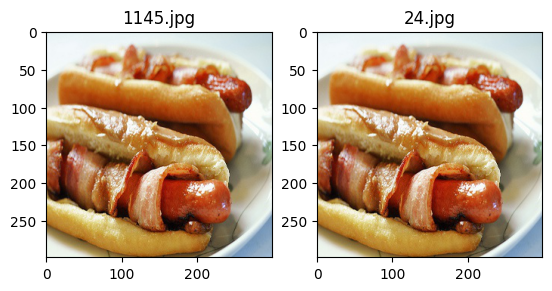

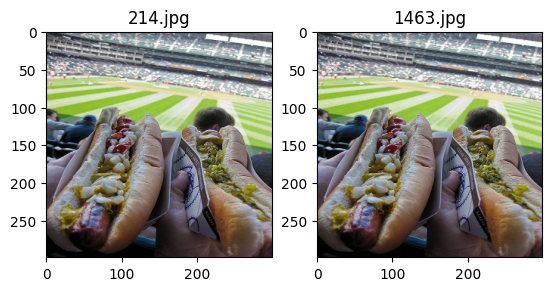

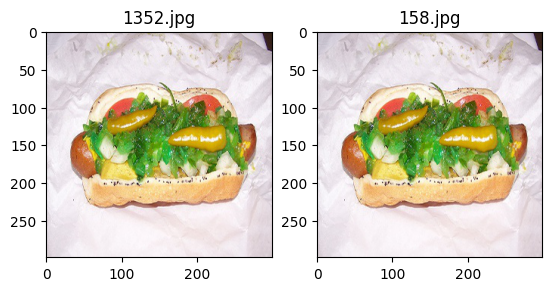

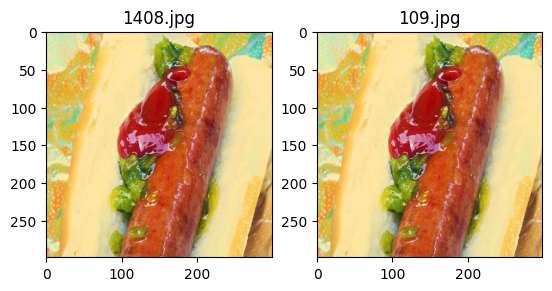

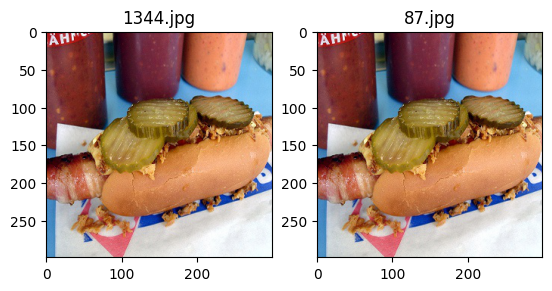

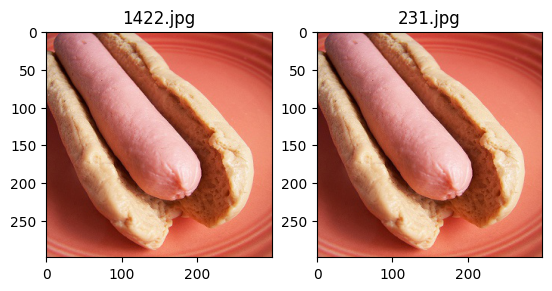

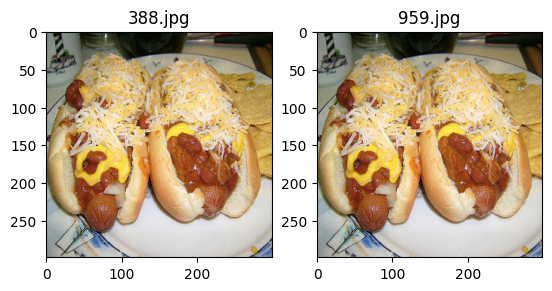

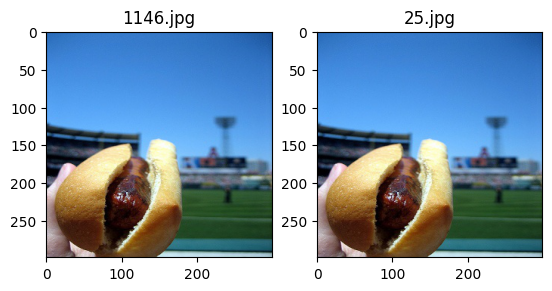

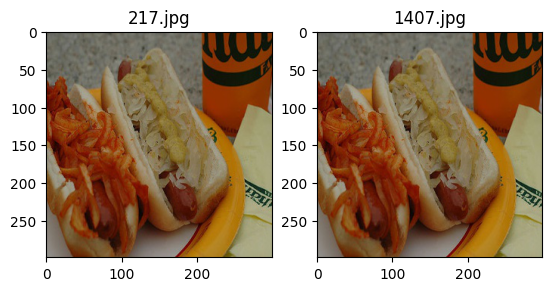

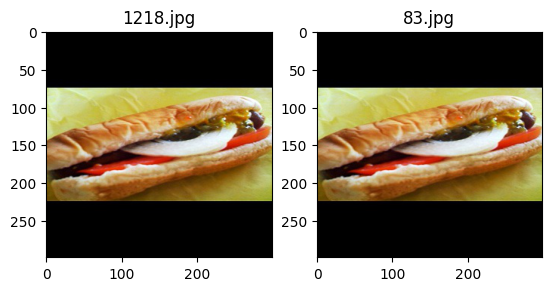

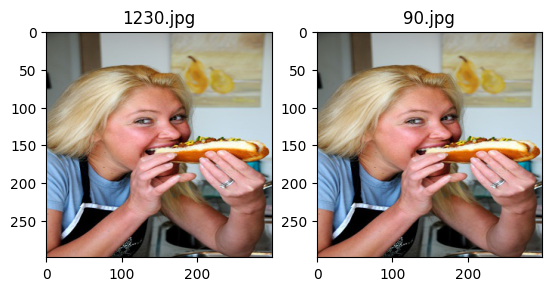

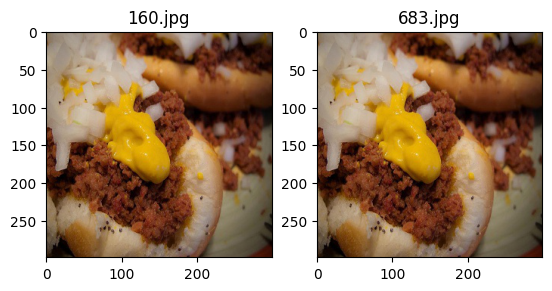

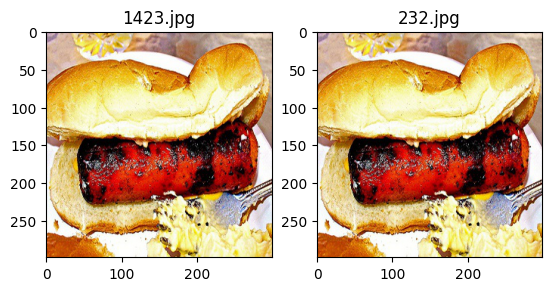

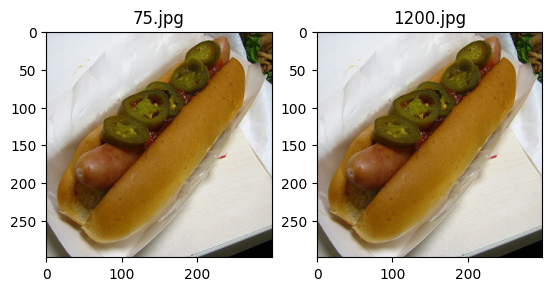

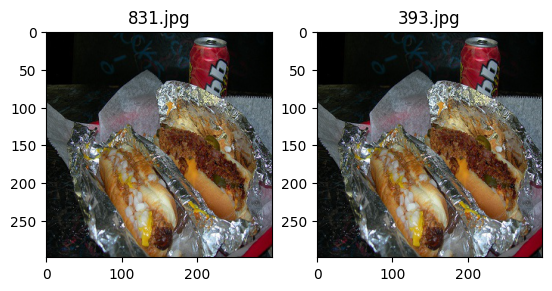

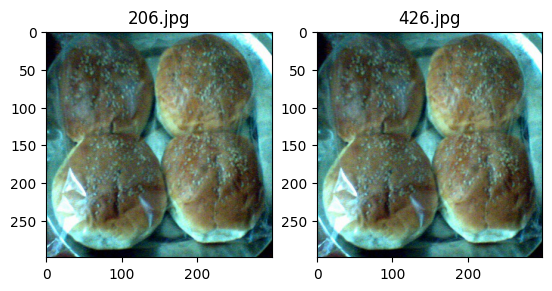

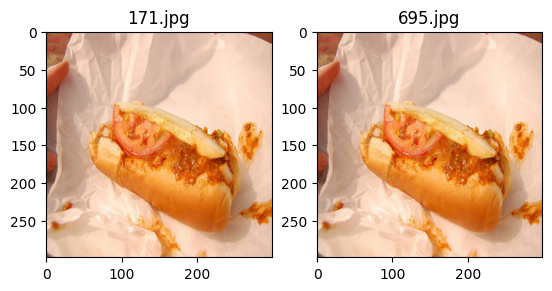

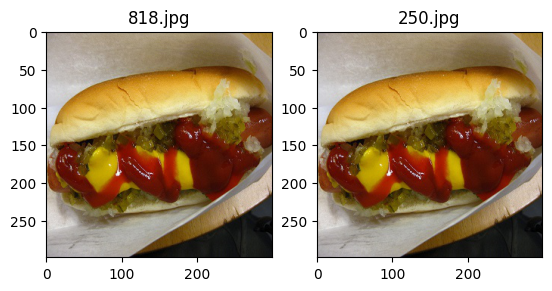

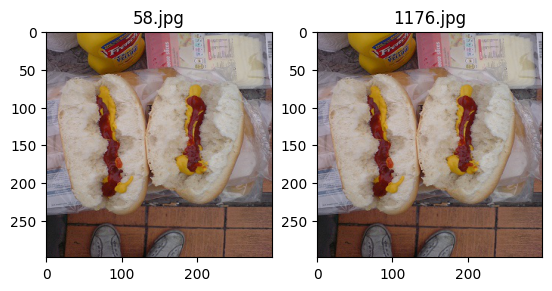

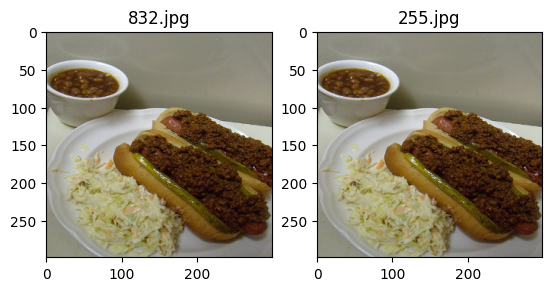

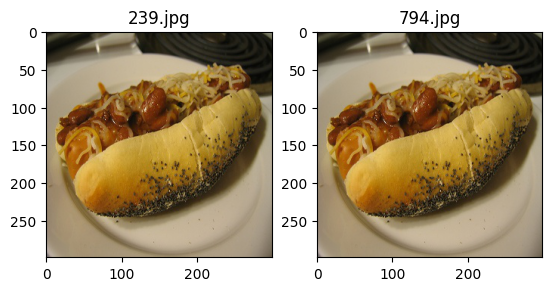

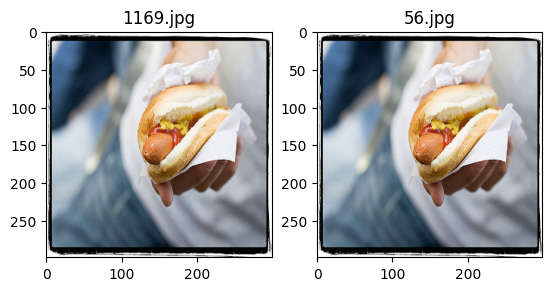

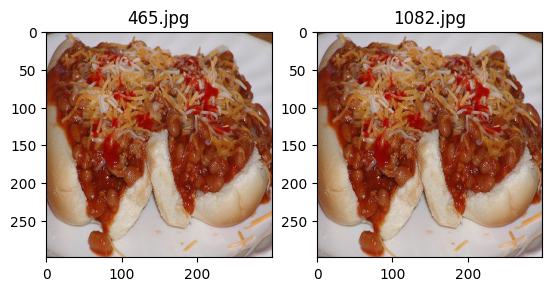

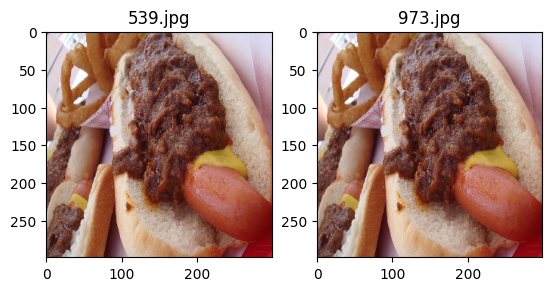

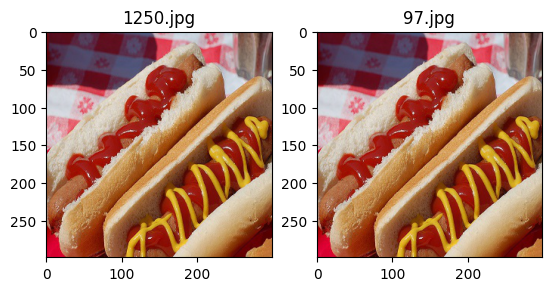

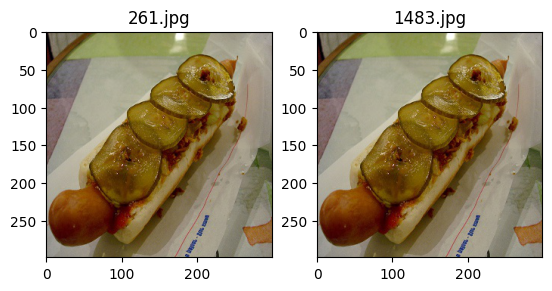

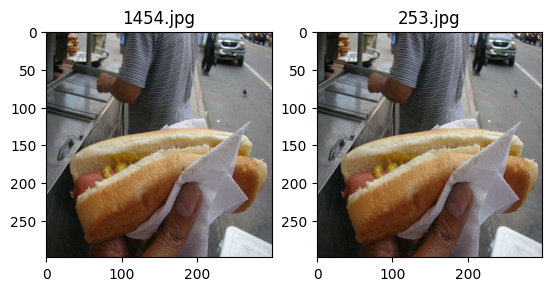

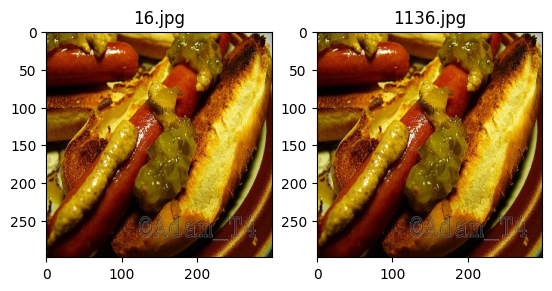

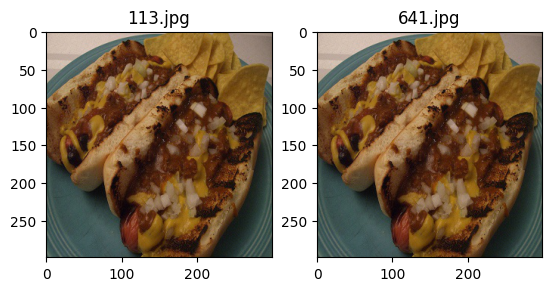

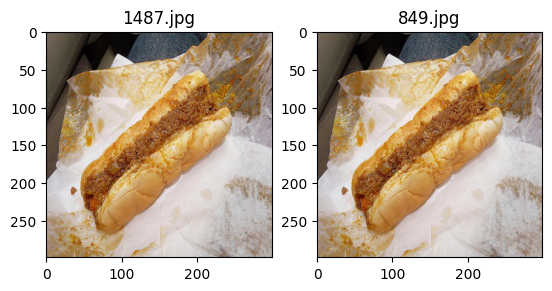

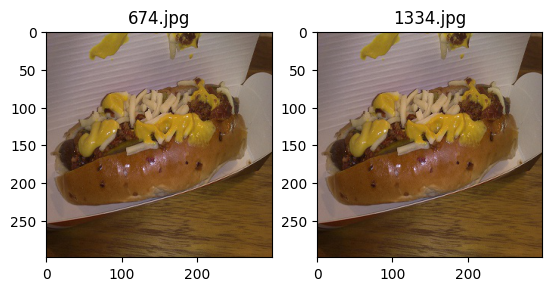

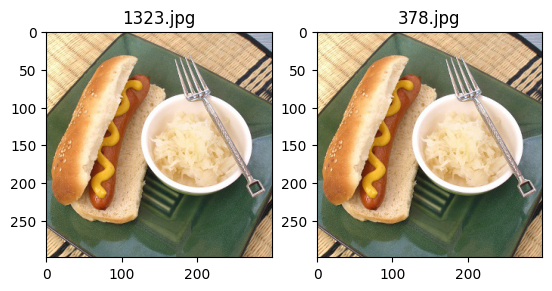

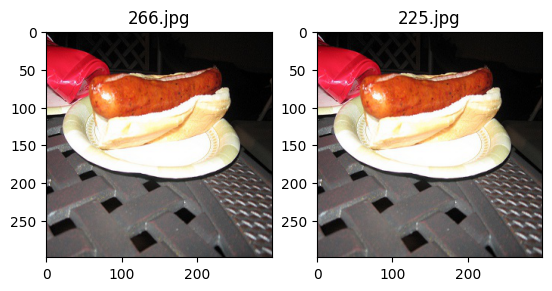

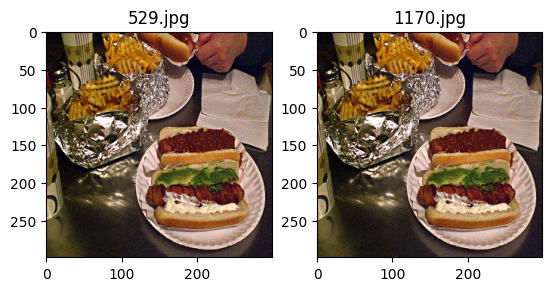

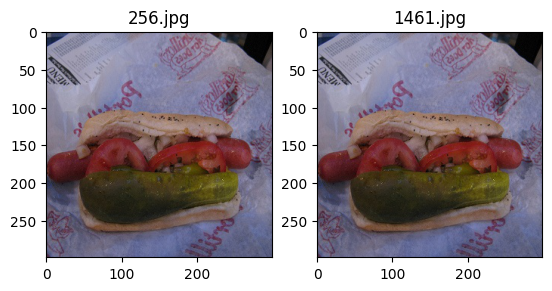

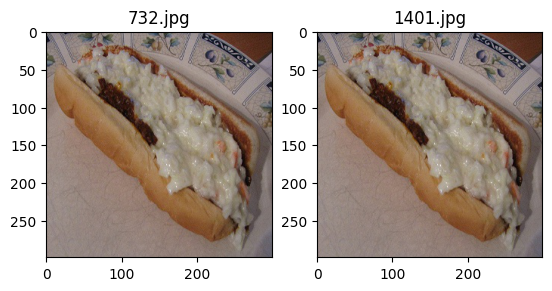

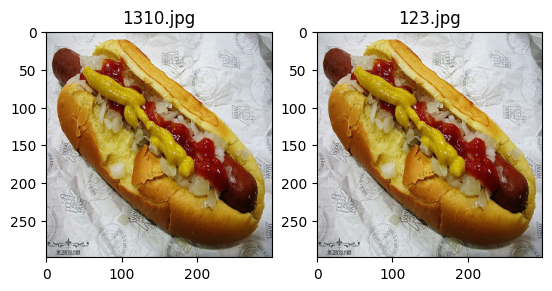

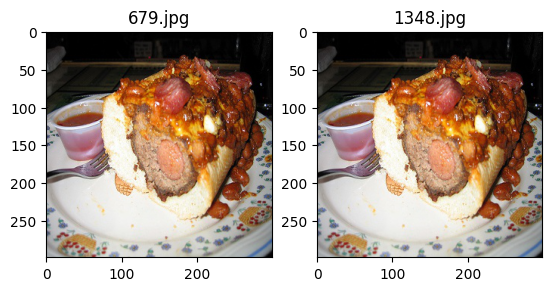

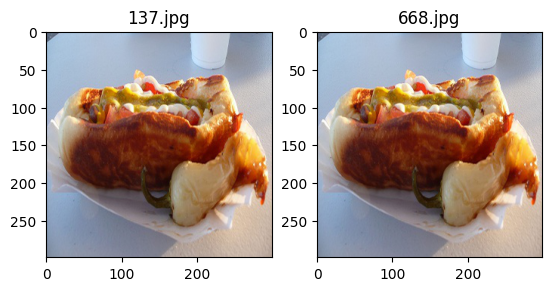

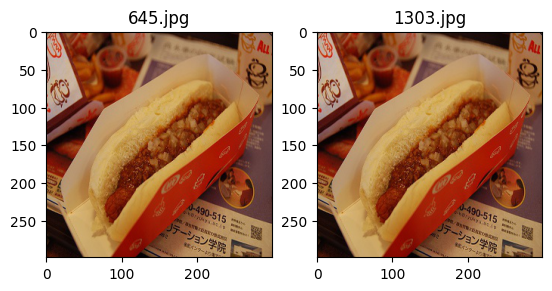

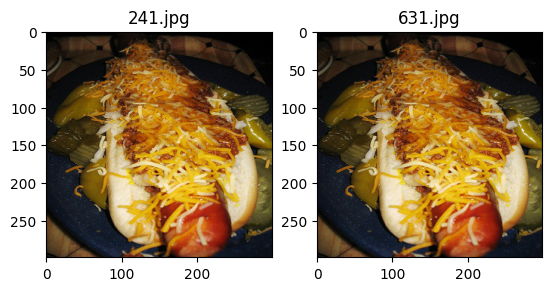

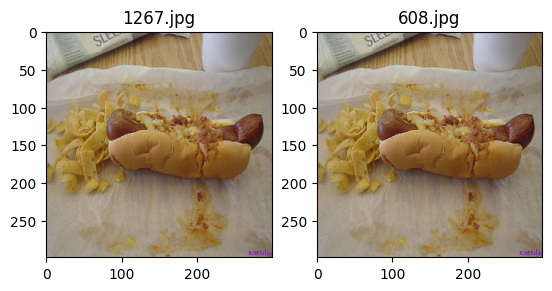

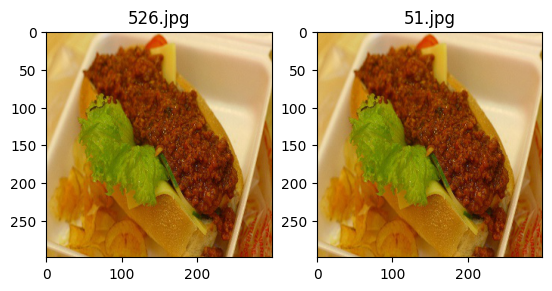

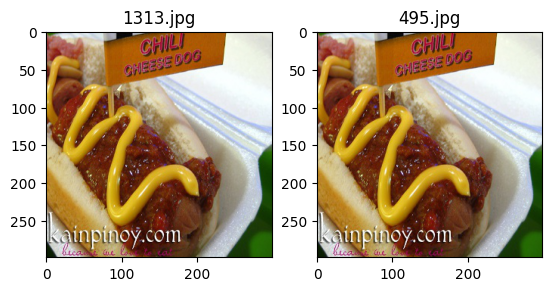

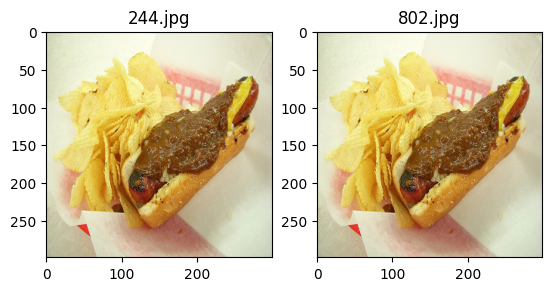

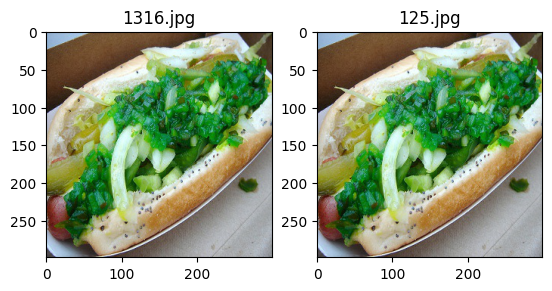

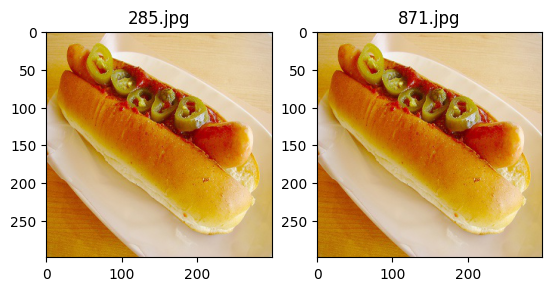

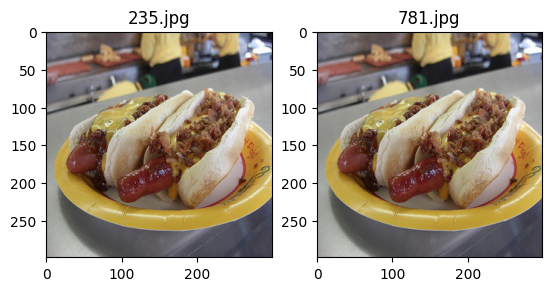

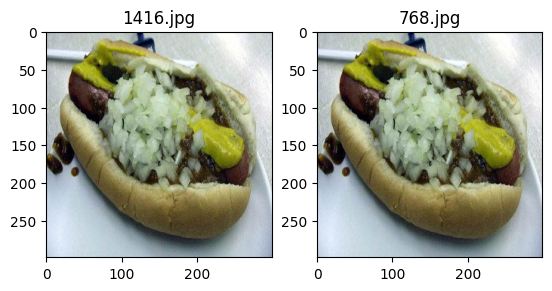

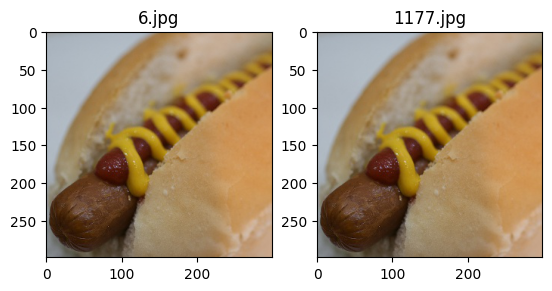

In [6]:
hotdog_duplicates_number = delete_duplicates(hotdog_directory)
not_hotdog_duplicates_number = delete_duplicates(not_hotdog_directory)

In [7]:
print(f'Number of hotdog duplicates in train dataset: {hotdog_duplicates_number}')
print(f'Percentage: {(hotdog_duplicates_number / hotdog_images_len) * 100:.2f}%\n')

print(f'Number of not hotdog duplicates in train dataset: {not_hotdog_duplicates_number}')
print(f'Percentage: {(not_hotdog_duplicates_number / not_hotdog_images_len) * 100:.2f}%\n')

Number of hotdog duplicates in train dataset: 50
Percentage: 3.33%

Number of not hotdog duplicates in train dataset: 0
Percentage: 0.00%



# ***Finding outliers***

In [8]:
model = resnet18(weights=ResNet18_Weights.DEFAULT).eval()

transforms = v2.Compose([v2.ToImage(), 
                         v2.ToDtype(torch.float32, scale=True),
                         v2.Normalize(mean=[0.485, 0.456, 0.406],
                                      std=[0.229, 0.224, 0.225])])

In [9]:
def get_feature_maps(model, path):
    batch_size = 1
    feature_maps_by_batch = []
    
    images, images_filenames = get_images(path)
    images_transformed = torch.stack(transforms(images))
    close_images(images)
    
    rest_size = len(images_transformed) % batch_size
    last_i = len(images_transformed) - rest_size
    
    for i in range(0, len(images_transformed), batch_size):
        if i == last_i:
            x = images_transformed[i:i + rest_size]
        else:
            x = images_transformed[i:i + batch_size]
            
        for layer in list(model.children())[:-1]:
            x = layer(x)
            
        feature_maps_by_batch.append(x)
        
    feature_maps = torch.cat(feature_maps_by_batch)
    
    return feature_maps, images_filenames

In [ ]:
hotdog_feature_maps, hotdog_filenames = get_feature_maps(model, hotdog_directory)
hotdog_feature_maps.detach_().squeeze_()

In [ ]:
clustering = cluster.AffinityPropagation()
clustering.fit(hotdog_feature_maps.numpy())

unique_labels = set(clustering.labels_)

print('Number of clusters: ', len(unique_labels) - (1 if -1 in unique_labels else 0))

In [ ]:
for label in unique_labels:
    label_filenames = np.array(hotdog_filenames)[clustering.labels_ == label]
    if not os.path.isdir(f'clusters/{label}'):
        os.mkdir(f'clusters/{label}')
    for label_filename in label_filenames:
        image = Image.open(f'{hotdog_directory}/{label_filename}')
        image.save(f'clusters/{label}/{label_filename}')
        image.close()

In [ ]:
images_count_by_dirs = [len(os.listdir(f'clusters/{label}')) for label in unique_labels]
list(zip(images_count_by_dirs, unique_labels))

5(3) 9(1) 14(6) 16(1) 18(1) 19(1) 21(1) 31(6) 37(1) 40(4) 48(1) 50(1) 51(1) 55(1) 56(4) 60(1) 88(6) 

In [ ]:
files_to_delete =  {'5': [],
                    '9': [],
                    '14': ['219', '297', '302', '432', '1142', '1265'],
                    '16': [],
                    '18': ['95'],
                    '19': ['344'],
                    '21': ['157'],
                    '31': ['73', '118', '154', '206', '212', '351'],
                    '37': ['313'],
                    '40': ['168', '184', '269', '318'],
                    '48': ['1317'],
                    '50': ['662'],
                    '51': [],
                    '55': ['417'],
                    '56': [],
                    '60': ['145'],
                    '88': ['141', '286', '376', '386', '1173', '1198']}

In [ ]:
outliers_num = 0
for dirname, filenames in files_to_delete.items():
    if len(filenames) == 0:
        for filename in os.listdir(f'clusters/{dirname}'):
            outliers_num += 1
            image = Image.open(f'clusters/{dirname}/{filename}')
            plt.imshow(image)
            plt.show()
            image.close()
            os.remove(f'{train_dataset_directory}/hotdog/{filename}')
    else:
        for filename in filenames:
            outliers_num += 1
            image = Image.open(f'clusters/{dirname}/{filename}.jpg')
            plt.imshow(image)
            plt.show()
            image.close()
            os.remove(f'{train_dataset_directory}/hotdog/{filename}.jpg')

In [ ]:
print(f'Number of outliers: {outliers_num}')
print(f'Percentage: {(outliers_num / (hotdog_images_len - hotdog_duplicates_number)) * 100:.2f}%')